# Import necessary libraries and modules

In [36]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import cv2
import imageio
import multiprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import ModelCheckpoint

# Plan
* 
* Find corrupted images
* 

In [37]:
train_dir_img = '/kaggle/input/airbus-ship-detection/train_v2/'
test_dir_img = '/kaggle/input/airbus-ship-detection/test_v2/'
train_dir_csv = os.path.join('/kaggle/input/airbus-ship-detection/',
                                 'train_ship_segmentations_v2.csv')

In [38]:
masks = pd.read_csv(train_dir_csv)
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0])
masks.head(30)

231723 masks found
192556


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...
8,0001b1832.jpg,NaN
9,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...


In [39]:
image_file = masks['ImageId'].iloc[2]  # Get the name of the image from DataFrame
image_path = train_dir_img + image_file  

image = cv2.imread(image_path)

height = image.shape[0]
width = image.shape[1]
num_channels = image.shape[2]
print(height, width, num_channels)

768 768 3


In [40]:
def display_encoded_pixels_train(image_num, shape=(height, width)):
    image_file = masks['ImageId'].iloc[image_num]  # Get the name of the image from DataFrame
    image_path = train_dir_img + image_file  
    
    # Load and display the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV reads images in BGR format, so convert it to RGB
    
    mask_img = np.zeros((shape[0] * shape[1], 1), dtype=int)
    l,b=cv2.imread(image_path).shape[0], cv2.imread(image_path).shape[1]
    
    if pd.isna(masks['EncodedPixels'].iloc[image_num]):
        print("No ships")
    else:
        masks['EncodedPixels'].iloc[image_num].split(' ')
        rle = list(map(int, masks['EncodedPixels'].iloc[image_num].split(' ')))
        pixel,pixel_count = [],[]
        [pixel.append(rle[i]) if i % 2 ==0 else pixel_count.append(rle[i]) for i in range(0, len(rle))]
        rle_pixels = [list(range(pixel[i],pixel[i]+pixel_count[i])) for i in range(0, len(pixel))]
        rle_mask_pixels = sum(rle_pixels,[]) 
        mask_img[rle_mask_pixels] = 255
        
    mask = np.reshape(mask_img, (b, l)).T 
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    axes[1].imshow(mask)
    axes[1].set_title('Segmented Image')
    axes[1].axis('off')

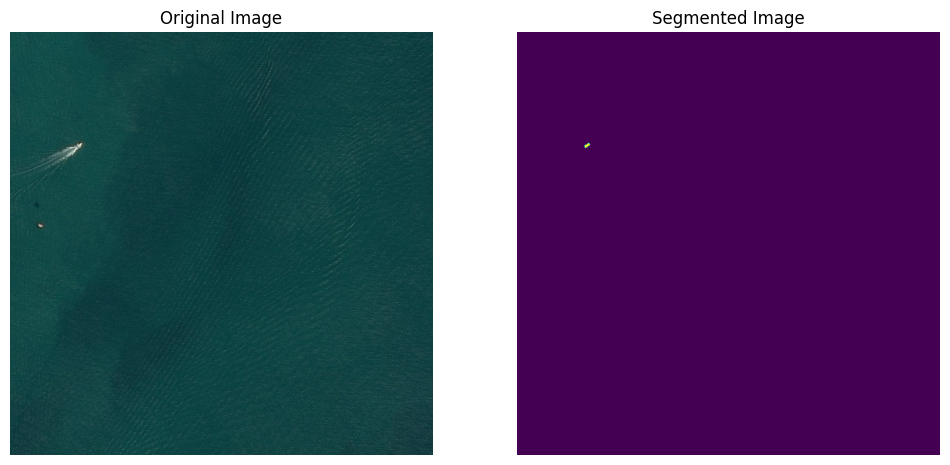

In [41]:
display_encoded_pixels_train(458, (height, width))

In [42]:
not_empty = pd.notna(masks.EncodedPixels)
print(not_empty.sum(), 'masks in', masks[not_empty].ImageId.nunique(), 'images')
print((~not_empty).sum(), 'empty images in', masks.ImageId.nunique(), 'total images')
masks.head()

81723 masks in 42556 images
150000 empty images in 192556 total images


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


# Notes
* Some images has different ships on it
* Size of image is (768, 768, 3)
* Numbers of unique images: 192556
* 150000 empty images
* 81723 masks in 42556 images

Conclution:
* Class imbalance problem (too much images without ships, maybe change train dataset to 70% images with ships, 30% images without ships)
* it's necessary to combine ship masks for each photo (if there is more than one ship in the photo)
* Add validation dataset or cross-validation

In [43]:
def is_image_corrupted(directory, filename):
        filepath = os.path.join(directory, filename)
        try:
            img = imageio.imread(filepath)
            pass
        except Exception as e:
            return filename
        return None
def find_corrupted_images_parallel(directory):
    # Get list of image filenames
    filenames = os.listdir(directory)

    # Create a pool of worker processes
    with multiprocessing.Pool() as pool:
        # Distribute the task of checking images across worker processes
        corrupted_images = pool.starmap(is_image_corrupted, [(directory, filename) for filename in filenames])

    # Filter out None values (indicating no corruption) and return list of corrupted images
    return [filename for filename in corrupted_images if filename is not None]

In [44]:
#corrupted_images_train = find_corrupted_images_parallel(train_dir_img)
# print("Corrupted images", corrupted_images_train)

In [45]:
# corrupted_images_test = find_corrupted_images_parallel(test_dir_img)
# print("Corrupted images", corrupted_images_test)

* So, Corrupted images ['6384c3e78.jpg'] in train set. Deleting it

* No corrupted images in test set


In [46]:
сorrupted_images = ['6384c3e78.jpg']

In [47]:
def combine_masks(encoded_pixels):
    masks = ' '.join(map(str, encoded_pixels))
    return masks


def process_image(image_id, group):
    encoded_pixels = group['EncodedPixels'].tolist()
    if np.all(pd.notna(encoded_pixels)):
        combined_mask = combine_masks(encoded_pixels)
        return image_id, combined_mask, len(group)
    else:
        return image_id, None, 0  

def parallel_process(data, func, num_processes=4):
    with multiprocessing.Pool(num_processes) as pool:
        return pool.starmap(func, data)


In [48]:
masks = masks[masks['ImageId'] != '6384c3e78.jpg']

In [49]:
grouped_data = masks.groupby('ImageId')

In [50]:
image_data = [(group_name, group) for group_name, group in grouped_data]
processed_results = parallel_process(image_data, process_image)

result_df = pd.DataFrame(processed_results, columns=['ImageId', 'CombinedMask', 'NumShips'])

In [51]:
number_img_train = len(result_df)
print(number_img_train)

192555


In [52]:
result_df.head(10)

,ImageId,CombinedMask,NumShips
0,00003e153.jpg,None,0
1,0001124c7.jpg,None,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,5
4,0001b1832.jpg,None,0
5,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...,9
6,0002756f7.jpg,255784 2 256552 4 257319 7 258087 9 258854 12 ...,2
7,0002d0f32.jpg,None,0
8,000303d4d.jpg,None,0
9,00031f145.jpg,340363 1 341129 4 341896 6 342663 7 343429 10 ...,1


In [53]:
number_img_train = 100

In [54]:
has_ships = result_df[result_df['NumShips'] != 0]
no_ships = result_df[result_df['NumShips'] == 0]

print(len(has_ships), len(no_ships))
has_ships.head()

42556 149999


,ImageId,CombinedMask,NumShips
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,5
5,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...,9
6,0002756f7.jpg,255784 2 256552 4 257319 7 258087 9 258854 12 ...,2
9,00031f145.jpg,340363 1 341129 4 341896 6 342663 7 343429 10 ...,1


In [55]:
number_img_train_noships = int(number_img_train * 0.4)
number_img_train_ships = number_img_train - number_img_train_noships

In [56]:
def display_encoded_pixels_train_res(image_num, shape=(height, width)):
    image_file = has_ships['ImageId'].iloc[image_num]  # Get the name of the image from DataFrame
    image_path = train_dir_img + image_file  
    
    # Load and display the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV reads images in BGR format, so convert it to RGB
    
    mask_img = np.zeros((shape[0] * shape[1], 1), dtype=int)
    l,b=cv2.imread(image_path).shape[0], cv2.imread(image_path).shape[1]
    
    if pd.isna(has_ships['CombinedMask'].iloc[image_num]):
        print("No ships")
    else:
        has_ships['CombinedMask'].iloc[image_num].split(' ')
        rle = list(map(int, has_ships['CombinedMask'].iloc[image_num].split(' ')))
        pixel,pixel_count = [],[]
        [pixel.append(rle[i]) if i % 2 ==0 else pixel_count.append(rle[i]) for i in range(0, len(rle))]
        rle_pixels = [list(range(pixel[i],pixel[i]+pixel_count[i])) for i in range(0, len(pixel))]
        rle_mask_pixels = sum(rle_pixels,[]) 
        mask_img[rle_mask_pixels] = 1
        
    mask = np.reshape(mask_img, (b, l)).T 
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    print(has_ships.iloc[image_num])
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    axes[1].imshow(mask)
    axes[1].set_title('Segmented Image')
    axes[1].axis('off')

ImageId                                             0005d01c8.jpg
CombinedMask    56010 1 56777 3 57544 6 58312 7 59079 9 59846 ...
NumShips                                                        2
Name: 15, dtype: object


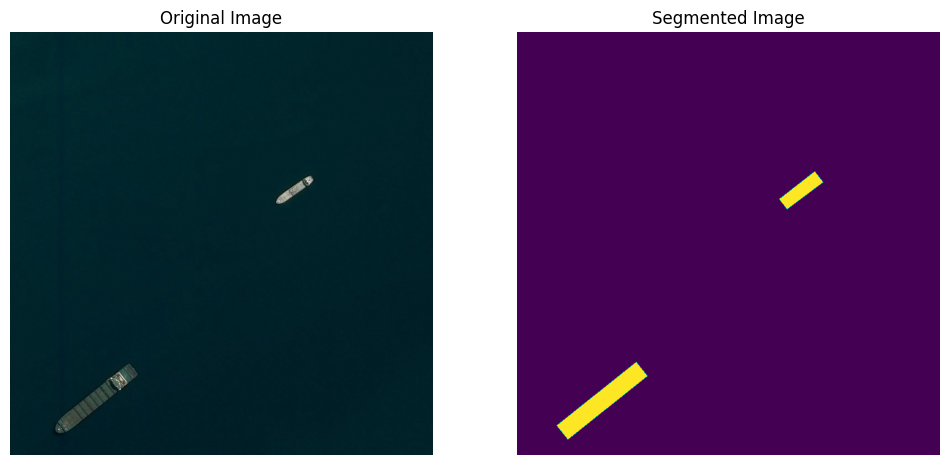

In [57]:
display_encoded_pixels_train_res(7, (height, width))

In [58]:
no_ships_less = no_ships[: number_img_train_noships]
has_ships = has_ships[: number_img_train_ships]

In [59]:
def decode_rle(encoded_pixels, shape):
    mask_img = np.zeros((shape[0] * shape[1], 1), dtype=int)
    
    if pd.notna(encoded_pixels):
        # Розбиваємо рядок кодованих пікселів на числа
        rle = list(map(int, encoded_pixels.split(' ')))
        
        # Створюємо списки для зберігання позицій пікселів та їх кількостей
        pixel, pixel_count = [], []
        
        # Розділяємо коди пікселів та їх кількостей
        [pixel.append(rle[i]) if i % 2 == 0 else pixel_count.append(rle[i]) for i in range(0, len(rle))]
        
        # Створюємо список позицій пікселів для кожного RLE-коду
        rle_pixels = [list(range(pixel[i], pixel[i] + pixel_count[i])) for i in range(0, len(pixel))]
        
        # Об'єднуємо списки пікселів для отримання всіх пікселів маски
        rle_mask_pixels = sum(rle_pixels, [])
        
        try:
            mask_img[rle_mask_pixels] = 255
        except IndexError:
            pass
        
    # Повертаємо маску в форматі, придатному для використання в моделі
    return np.reshape(mask_img, (shape[1], shape[0])).T


In [60]:
X_train_pos, X_val_pos, y_train_pos, y_val_pos = train_test_split(has_ships['ImageId'], has_ships['CombinedMask'], test_size=0.15, random_state=47)
X_train_neg, X_val_neg, y_train_neg, y_val_neg = train_test_split(no_ships_less['ImageId'], no_ships_less['CombinedMask'], test_size=0.15, random_state=47)
X_train = np.concatenate((X_train_pos, X_train_neg))
X_val = np.concatenate((X_val_pos, X_val_neg))
y_train = np.concatenate((y_train_pos, y_train_neg))
y_val = np.concatenate((y_val_pos, y_val_neg))

In [61]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model


In [62]:
model = build_unet((height, width, 3))
# model.summary()

In [63]:
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=[MeanIoU(num_classes=2)])
checkpoint = ModelCheckpoint("/kaggle/working/unet_model.h5", monitor='val_loss', verbose=1, save_best_only=True)

In [64]:
batch_size = 16
steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_val) // batch_size

In [65]:
def preprocess_image(image):
    # Нормалізуємо значення пікселів в діапазоні [0, 1]
    image = image / 255.0
    
    return image

In [66]:
def data_generator(X, y, batch_size):
    while True:
        for i in range(0, len(X), batch_size):
            batch_X = []
            batch_y = []
            for j in range(i, min(i+batch_size, len(X))):
                # Завантажити та обробити зображення
                image_path = train_dir_img + X[j]
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV reads images in BGR format, so convert it to RGB
                image = preprocess_image(image)
                batch_X.append(image)
                # Декодувати закодовану маску та обробити маску
                mask = decode_rle(y[j], (height, width))
                batch_y.append(mask)
            yield np.array(batch_X), np.array(batch_y)

In [67]:
history = model.fit(data_generator(X_train, y_train, batch_size),
                    steps_per_epoch=steps_per_epoch,
                    epochs=10,
                    validation_data=data_generator(X_val, y_val, batch_size),
                    validation_steps=validation_steps,
                    callbacks=[checkpoint])

# Оцінка моделі на валідаційному наборі
loss, mean_iou = model.evaluate(data_generator(X_val, y_val, batch_size), steps=validation_steps)
print("Втрата на валідації:", loss)
print("Середнє IoU:", mean_iou)

Epoch 1/10


ResourceExhaustedError: Graph execution error:

Detected at node UNET/batch_normalization_21/FusedBatchNormV3 defined at (most recent call last):
  File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code

  File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_34/885105321.py", line 1, in <module>

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py", line 597, in call

  File "/opt/conda/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py", line 990, in _fused_batch_norm

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/control_flow_util.py", line 108, in smart_cond

  File "/opt/conda/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py", line 964, in _fused_batch_norm_training

Detected at node UNET/batch_normalization_21/FusedBatchNormV3 defined at (most recent call last):
  File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code

  File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_34/885105321.py", line 1, in <module>

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py", line 597, in call

  File "/opt/conda/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py", line 990, in _fused_batch_norm

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/control_flow_util.py", line 108, in smart_cond

  File "/opt/conda/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py", line 964, in _fused_batch_norm_training

2 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[16,128,384,384] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node UNET/batch_normalization_21/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[confusion_matrix/assert_less_1/Assert/AssertGuard/pivot_f/_31/_79]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[16,128,384,384] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node UNET/batch_normalization_21/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_19201]

In [ ]:
image_path = test_dir_img + '00e5fb033.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV reads images in BGR format, so convert it to RGB
image = preprocess_image(image)
image = np.expand_dims(image, axis=0)  # Add a batch dimension

In [ ]:
predictions = model.predict(np.array(image))

In [ ]:
def display_res(image_path, predictions):
    
    
    # Load and display the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV reads images in BGR format, so convert it to RGB
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    axes[1].imshow(predictions)
    axes[1].set_title('Segmented Image')
    axes[1].axis('off')

In [ ]:
threshold = 0.5  # Adjust this threshold as needed

# Apply the threshold to the predictions
mask = np.where(predictions > threshold, 1, 0)

# Convert the mask to the appropriate data type
mask = mask.astype(np.uint8)

In [ ]:
display_res(image_path, predictions)